<a href="https://colab.research.google.com/github/GZhorzholiani/Module_4_assignment/blob/main/LLM_all_code_gpt2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

tiktoken version :  0.9.0
CUDA available: True
Device name: NVIDIA A100-SXM4-40GB
Device: cuda
Train loader:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])

Validation loader:
torch.Size([2, 256]) torch.Size([2, 256])
9
1
Training tokens: 4608
Validation tokens: 512
All tokens: 5120
Ep 1 (Step 000000): Train loss 9.919, Val loss 10.064
Ep 1 (Step 000005): Train loss 7.935, Val loss 8.277
Every effort moves you,,,,,,,,,,,,.                                     
Ep 2 (Step 000010): Train loss 6.495, Val loss 7.007
Ep 2 (Step 000015): Train loss 5.889, Val loss 6.531
Every effort moves you, and, and the           ", and, and, and, and, and, and the, and the, and, a

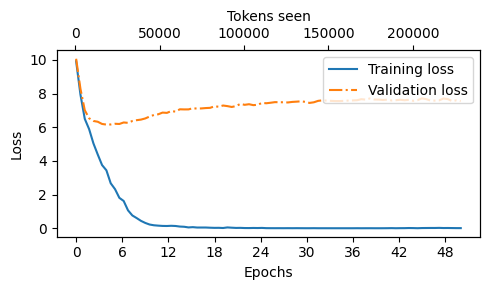

In [ ]:
import torch
import torch.nn as nn
!pip install tiktoken
import importlib
import tiktoken
print('tiktoken version : ',importlib.metadata.version('tiktoken'))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("CUDA available:", torch.cuda.is_available())
print("Device name:", torch.cuda.get_device_name(0))
print("Device:", device)

with open('/content/drive/MyDrive/Large Language Models/data/verdict.txt','r',encoding='utf-8') as f:
  text_data=f.read()
from torch.utils.data import Dataset,DataLoader

class GPTDatasetV1(Dataset):
  def __init__(self,txt,tokenizer,max_length,stride):
    self.input_ids=[]
    self.target_ids=[]

    token_ids=tokenizer.encode(txt,allowed_special={'<|endoftext|>'})

    for i in range(0,len(token_ids)-max_length,stride):
      input_chunk=token_ids[i:i+max_length]
      target_chunk=token_ids[i+1:i+max_length+1]
      self.input_ids.append(torch.tensor(input_chunk))
      self.target_ids.append(torch.tensor(target_chunk))
  def __len__(self):
    return len(self.input_ids)
  def __getitem__(self,idx):
    return self.input_ids[idx],self.target_ids[idx]


def create_dataloader_v1(txt,batch_size=4,max_length=256,stride=128,shuffle=True,drop_last=True,num_workers=0):
  tokenizer=tiktoken.get_encoding('gpt2')
  dataset=GPTDatasetV1(txt,tokenizer,max_length,stride)

  dataloader=DataLoader(
      dataset,
      batch_size=batch_size,
      shuffle=shuffle,
      drop_last=drop_last,
      num_workers=num_workers
  )
  return dataloader
GPT_CONDIG_124M={
    'vocab_size':50257,
    'context_length':256,
    'emb_dim':768,
    'n_heads':12,
    'n_layers':12,
    'drop_rate':0.1,
    'qkv_bias':False
}
train_ratio=0.90
split_idx=int(train_ratio*len(text_data))
train_data=text_data[:split_idx]
val_data=text_data[split_idx:]

torch.manual_seed(123)

train_loader=create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=GPT_CONDIG_124M['context_length'],
    stride=GPT_CONDIG_124M['context_length'],
    shuffle=True,
    drop_last=True,
    num_workers=0
)

val_loader=create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONDIG_124M['context_length'],
    stride=GPT_CONDIG_124M['context_length'],
    shuffle=False,
    drop_last=False,
    num_workers=0
)
print("Train loader:")
for x, y in train_loader:
    print(x.shape, y.shape)

print("\nValidation loader:")
for x, y in val_loader:
    print(x.shape, y.shape)

print(len(train_loader))
print(len(val_loader))

train_tokens = 0
for input_batch, target_batch in train_loader:
    train_tokens += input_batch.numel()

val_tokens = 0
for input_batch, target_batch in val_loader:
    val_tokens += input_batch.numel()

print("Training tokens:", train_tokens)
print("Validation tokens:", val_tokens)
print("All tokens:", train_tokens + val_tokens)
class MultiHeadAttention(nn.Module):
  def __init__(self,d_in,d_out,context_length,dropout,num_heads,qkv_bias=False):
    super().__init__()
    assert (d_out % num_heads==0),\
      'd_out must be divisible by num_heads'

    self.d_out=d_out
    self.num_heads=num_heads
    self.head_dim=d_out//num_heads

    self.W_query=nn.Linear(d_in,d_out,bias=qkv_bias)
    self.W_key=nn.Linear(d_in,d_out,bias=qkv_bias)
    self.W_value=nn.Linear(d_in,d_out,bias=qkv_bias)
    self.out_proj=nn.Linear(d_out,d_out)
    self.dropout=nn.Dropout(dropout)
    self.register_buffer("mask",torch.triu(torch.ones(context_length,context_length),diagonal=1))

  def forward(self,x):
    b,num_tokens,d_in=x.shape

    keys=self.W_key(x)  #shape:(b,num_tokens,d_out)(2,4,6 (num_heads==2))
    queries=self.W_query(x)
    values=self.W_value(x)

    #(b,num_tokens,d_out)>(b,num_tokens,num_heads,head_dim)(2,4,6 > 2,4,2,3)
    keys=keys.view(b,num_tokens,self.num_heads,self.head_dim)
    queries=queries.view(b,num_tokens,self.num_heads,self.head_dim)
    values=values.view(b,num_tokens,self.num_heads,self.head_dim)

    keys=keys.transpose(1,2)   #(b,num_tokens,num_heads,head_dim)>(b,num_heads,num_tokens,head_dim)
    values=values.transpose(1,2)
    queries=queries.transpose(1,2)

    attn_scores=queries @ keys.transpose(2,3) #(b,num_heads,num_tokens,head_dim) @ ((b,num_heads,head_dim,num_tokens))
    #attn_score.shape=(b,num_heads,num_tokens,num_tokens)

    mask_bool=self.mask.bool()[:num_tokens,:num_tokens] #Applying masking
    attn_scores = attn_scores.masked_fill(mask_bool, -torch.inf)



    attn_weights=torch.softmax(attn_scores/keys.shape[-1]**0.5,dim=-1) #applying scale and softmax
    attn_weights=self.dropout(attn_weights)

    context_vec=(attn_weights@values).transpose(1,2) #-->(b,num_tokens,num_heads,head_dim)
    context_vec=context_vec.contiguous().view(b,num_tokens,self.d_out) #(b,num_tokens,self.d_out)
    context_vec=self.out_proj(context_vec)

    return context_vec

class LayerNorm(nn.Module):
  def __init__(self,emb_dim):
    super().__init__()
    self.eps=1e-5
    self.scale=nn.Parameter(torch.ones(emb_dim))
    self.shift=nn.Parameter(torch.zeros(emb_dim))
  def forward(self,x):
    mean=x.mean(dim=-1,keepdim=True) #dim=-1 for columns keepdim = keep dimensions
    var=x.var(dim=-1,keepdim=True,unbiased=False) #unbiased=False = // n    not n-1 for var
    norm_x=(x-mean)/torch.sqrt(var+self.eps)
    return self.scale*norm_x+self.shift
class Gelu(nn.Module):
  def __init__(self):
    super().__init__()
  def forward(self,x):
    return 0.5*x*(1+torch.tanh(torch.sqrt(torch.tensor(2.0/torch.pi))*(x+0.044715*torch.pow(x,3))))
class FeedForward(nn.Module):
  def __init__(self,cfg):
    super().__init__()
    self.layers=nn.Sequential(
        nn.Linear(cfg['emb_dim'],4*cfg['emb_dim']),
        Gelu(),
        nn.Linear(4*cfg['emb_dim'],cfg['emb_dim'])
    )
  def forward(self,x):
    return self.layers(x)

class TransformerBlock(nn.Module):
  def __init__(self,cfg):
    super().__init__()
    self.att=MultiHeadAttention(
        d_in=cfg['emb_dim'],
        d_out=cfg['emb_dim'],
        context_length=cfg['context_length'],
        num_heads=cfg['n_heads'],
        dropout=cfg['drop_rate'],
        qkv_bias=cfg['qkv_bias'])
    self.ff=FeedForward(cfg)
    self.norm1=LayerNorm(cfg['emb_dim'])
    self.norm2=LayerNorm(cfg['emb_dim'])
    self.drop_shotcut=nn.Dropout(cfg['drop_rate'])

  def forward(self,x):
    shortcut=x
    x=self.norm1(x)
    x=self.att(x)
    x=self.drop_shotcut(x)
    x=x+shortcut

    shotcut=x
    x=self.norm2(x)
    x=self.ff(x)
    x=self.drop_shotcut(x)
    x=x+shortcut

    return x
class GPTModel(nn.Module):
  def __init__(self,cfg):
    super().__init__()
    self.tok_emb=nn.Embedding(cfg['vocab_size'],cfg['emb_dim'])
    self.pos_emb=nn.Embedding(cfg['context_length'],cfg['emb_dim'])
    self.drop_emb=nn.Dropout(cfg['drop_rate'])
    self.trf_blocks=nn.Sequential(
        *[TransformerBlock(cfg) for _ in range(cfg['n_layers'])])
    self.final_norm=LayerNorm(cfg['emb_dim'])
    self.out_head=nn.Linear(cfg['emb_dim'],cfg['vocab_size'],bias=False)
  def forward(self,in_idx):
    batch_size,seq_length=in_idx.shape
    tok_embeds=self.tok_emb(in_idx)
    pos_embeds=self.pos_emb(torch.arange(seq_length,device=in_idx.device))
    x=tok_embeds+pos_embeds
    x=self.drop_emb(x)
    x=self.trf_blocks(x)
    x=self.final_norm(x)
    logits=self.out_head(x)
    return logits

torch.manual_seed(123)
model=GPTModel(GPT_CONDIG_124M)
model.eval()
import torch
import tiktoken
import torch.nn.functional as F


tokenizer = tiktoken.get_encoding('gpt2')

# --- Text <-> Token Fonksiyonları ---
def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0)  # (batch_size, seq_len)
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0)  # (seq_len,)
    return tokenizer.decode(flat.tolist())

# --- Gelişmiş Generate Fonksiyonu ---
def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]

        with torch.no_grad():
            logits = model(idx_cond)

        logits = logits[:, -1, :]  # Son token prediction

        if top_k is not None:
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1].unsqueeze(-1)  # dikkat! batch boyutuna göre
            logits = torch.where(logits < min_val, torch.full_like(logits, float('-inf')), logits)

        if temperature > 0.0:
            logits = logits / temperature
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)  # sampling
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)  # greedy

        if eos_id is not None:
            if (idx_next == eos_id).all():
                break

        idx = torch.cat((idx, idx_next), dim=1)

    return idx



def calc_loss_batch(input_batch,target_batch,model,device):
  input_batch,target_batch=input_batch.to(device),target_batch.to(device)
  logits=model(input_batch)
  logits=logits.flatten(0,1)
  targets=target_batch.flatten()
  loss=torch.nn.functional.cross_entropy(logits,targets)
  return loss
def calc_loss_loader(data_loader, model, device, num_batches=None):
    model.eval()
    total_loss = 0.

    if len(data_loader) == 0:
        return float('nan')

    if num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))

    with torch.no_grad():  # Validation sırasında gradient hesabı yapmaya gerek yok
        for i, (input_batch, target_batch) in enumerate(data_loader):
            if i < num_batches:
                loss = calc_loss_batch(input_batch, target_batch, model, device)
                total_loss += loss.item()
            else:
                break

    model.train()  # Tekrar train moduna alıyoruz
    return total_loss / num_batches
def train_model_simple(model,train_loader,val_loader,optimizer,device,num_epochs,
                        eval_freq,eval_iter,start_context,tokenizer):
  train_losses,val_losses,track_tokens_seen=[],[],[]
  tokens_seen,global_step=0,-1

  for epoch in range(num_epochs):
    model.train()
    for input_batch,target_batch in train_loader:
      optimizer.zero_grad()
      loss=calc_loss_batch(input_batch,target_batch,model,device)
      loss.backward()
      optimizer.step()
      tokens_seen+=input_batch.numel()
      global_step +=1

      if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")
    generate_and_print_sample(model,tokenizer,device,start_context)
  return train_losses, val_losses, track_tokens_seen
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss
def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate(
            model=model, idx=encoded,
            max_new_tokens=50, context_size=context_size
        )
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " "))  # Compact print format
    model.train()
# Note:
# Uncomment the following code to calculate the execution time
import time
start_time = time.time()

torch.manual_seed(123)
model = GPTModel(GPT_CONDIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)

num_epochs = 50
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context="Every effort moves you", tokenizer=tokenizer
)

# Note:
# Uncomment the following code to show the execution time
end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))  # only show integer labels on x-axis

    # Create a second x-axis for tokens seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(tokens_seen, train_losses, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig("loss-plot.pdf")
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# --- Save checkpoint (Google Drive'a) ---
checkpoint = {
    'epoch': num_epochs,  # İstersen son epoch'u da kaydedebilirsin
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
}

torch.save(checkpoint, '/content/drive/MyDrive/gptmodel_checkpoint.pth')
print("Checkpoint saved to Drive!")

# --- Save full model (Google Drive'a) ---
torch.save(model, '/content/drive/MyDrive/gptmodel_full.pth')
print("Full model saved to Drive!")


Checkpoint saved to Drive!
Full model saved to Drive!


In [ ]:
# # 1. Model mimarisini tekrar oluştur
# model = GPTModel(GPT_CONDIG_124M)  # dikkat: config doğru olmalı
# model.to(device)

# # 2. Checkpoint'i yükle
# checkpoint = torch.load('/content/drive/MyDrive/gptmodel_checkpoint.pth', map_location=device)

# # 3. Model ağırlıklarını yükle
# model.load_state_dict(checkpoint['model_state_dict'])

# # 4. Optimizer'ı tekrar oluştur
# optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)

# # 5. Optimizer ağırlıklarını yükle
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# # 6. (Opsiyonel) Epoch bilgisini oku
# start_epoch = checkpoint['epoch'] + 1

# print("Model ve optimizer başarıyla yüklendi! Eğitim {}. epoch'tan devam edebilir.".format(start_epoch))


# # 1. Tüm modeli yükle
# model = torch.load('/content/drive/MyDrive/gptmodel_full.pth', map_location=device)

# # 2. Modeli device'a taşı
# model.to(device)

# # 3. Optimizer'ı tekrar oluştur (çünkü optimizer kaydedilmemiştir full modelde)
# optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)

# print("Full model başarıyla yüklendi!")
